# 0. Импорт библиотек

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

# Мы будем использовать метрику ROC_AUC
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from category_encoders import BinaryEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings('ignore')

# 1. Обработка датасета

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('orange_small_churn_test_data.csv')

## Избавимся от уж совсем бесполезных данных: полностью пустых колонн

In [3]:
y_train = train['0']

nonempty_columns = train.columns[np.sum(train.isna(), axis=0) < 34000]

numeric_columns = train.columns[1:191]
numeric_columns = numeric_columns & nonempty_columns

categorical_columns = train.columns[191:-1]
categorical_columns = categorical_columns & nonempty_columns

train = train[numeric_columns.append(categorical_columns)]

## Теперь попробуем произвести отбор признаков. Основным критерием полезности признака будет - отсутствие пустот.

### Посмотрим на распределение пустот

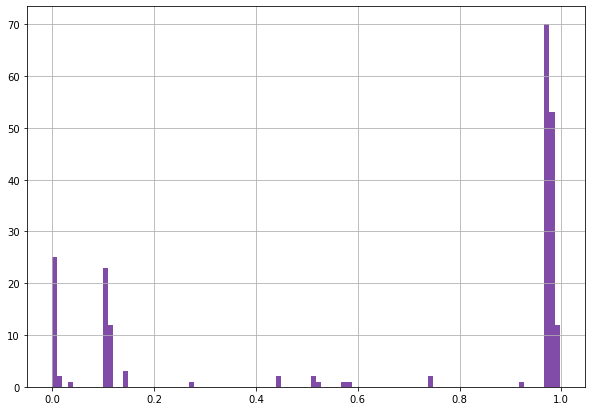

In [4]:
nan_dist = np.sum(train.isna())/34000
nan_dist.hist(figsize=(10, 7), color='indigo', bins=100, alpha=0.7);

### Мы видим, что очень много пустот сконцентрировались в последних пяти процентах

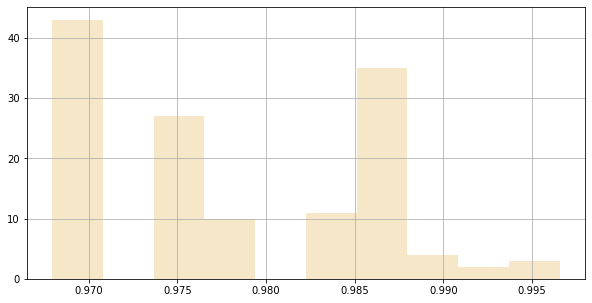

In [5]:
nan_dist[nan_dist>=0.95].hist(figsize=(10, 5), color='wheat', bins=10, alpha=0.7);

Так как catboost хорошо справяляется с заполненными признаками, нашей задачей является отбор признаков на заполнение. Гистограмма намекает на то, что можно использовать долю пустот, как параметр для отбора.

In [6]:
def emptization(data, cat_columns, num_columns, thresh=0.99):
    n = data.shape[0]
    
    cat_data = data[cat_columns]
    nan_cat_dist = np.sum(cat_data.isna()) / n
    cat_columns = nan_cat_dist[nan_cat_dist<thresh].index
    
    num_data = data[num_columns]
    nan_num_dist = np.sum(num_data.isna()) / n
    num_columns = nan_num_dist[nan_num_dist<thresh].index
    
    return cat_columns, num_columns

In [7]:
# cat_cols, num_cols = emptization(train, categorical_columns, numeric_columns)
cat_cols, num_cols = categorical_columns, numeric_columns

# 2. Заполнение средним

In [8]:
mean_numerical_values = train[num_cols].mean()

X_numeric = train[num_cols].fillna(mean_numerical_values)
X_categorical = train[cat_cols].fillna('Not_known')

X_test_numeric = test[num_cols].fillna(mean_numerical_values)
X_test_categorical = test[cat_cols].fillna('Not_known')

X_train = pd.concat([X_numeric, X_categorical], axis=1)
X_test = pd.concat([X_test_numeric, X_test_categorical], axis=1)

# 3. Отбор признаков при помощи Catboost

Catboost - не очень требователен к предварительной обработки. Мало того лучше в принципе не обрабатывать данные, используя методы категоризации по типу OneHotEncoding или бинарной категоризации. По крайней мере, по моему опыту: результат получался хуже.

Мало того, нам не надо делать классический тюнинг нашей модели по типу нахождения оптимального коэффициента регуляризации. Связано это с тем, что как видно ниже, наша модель сама изучает сколько итераций (сколько деревьев) нужно сделать для идеальной модели. Фактически, метод ранней остановки уже является L2-регуляризацией. Почитать об этом подробнее можно в DeepLearningBook параграф 7.8

In [9]:
data_train = Pool(data=X_train, label=y_train, cat_features=cat_cols)

In [10]:
model = CatBoostClassifier(eval_metric='AUC')

In [11]:
model.fit(data_train)

Learning rate set to 0.046438
0:	total: 293ms	remaining: 4m 52s
1:	total: 455ms	remaining: 3m 46s
2:	total: 622ms	remaining: 3m 26s
3:	total: 792ms	remaining: 3m 17s
4:	total: 934ms	remaining: 3m 5s
5:	total: 965ms	remaining: 2m 39s
6:	total: 1.08s	remaining: 2m 33s
7:	total: 1.23s	remaining: 2m 32s
8:	total: 1.37s	remaining: 2m 31s
9:	total: 1.52s	remaining: 2m 30s
10:	total: 1.69s	remaining: 2m 32s
11:	total: 1.73s	remaining: 2m 22s
12:	total: 1.87s	remaining: 2m 22s
13:	total: 2.01s	remaining: 2m 21s
14:	total: 2.18s	remaining: 2m 23s
15:	total: 2.35s	remaining: 2m 24s
16:	total: 2.5s	remaining: 2m 24s
17:	total: 2.53s	remaining: 2m 17s
18:	total: 2.59s	remaining: 2m 13s
19:	total: 2.65s	remaining: 2m 9s
20:	total: 2.72s	remaining: 2m 6s
21:	total: 2.83s	remaining: 2m 5s
22:	total: 2.98s	remaining: 2m 6s
23:	total: 3.17s	remaining: 2m 8s
24:	total: 3.24s	remaining: 2m 6s
25:	total: 3.39s	remaining: 2m 6s
26:	total: 3.56s	remaining: 2m 8s
27:	total: 3.72s	remaining: 2m 9s
28:	total: 

233:	total: 37s	remaining: 2m 1s
234:	total: 37.2s	remaining: 2m 1s
235:	total: 37.3s	remaining: 2m
236:	total: 37.5s	remaining: 2m
237:	total: 37.7s	remaining: 2m
238:	total: 37.9s	remaining: 2m
239:	total: 38s	remaining: 2m
240:	total: 38.2s	remaining: 2m
241:	total: 38.4s	remaining: 2m
242:	total: 38.5s	remaining: 2m
243:	total: 38.7s	remaining: 1m 59s
244:	total: 38.9s	remaining: 1m 59s
245:	total: 39s	remaining: 1m 59s
246:	total: 39.2s	remaining: 1m 59s
247:	total: 39.4s	remaining: 1m 59s
248:	total: 39.5s	remaining: 1m 59s
249:	total: 39.7s	remaining: 1m 59s
250:	total: 39.8s	remaining: 1m 58s
251:	total: 39.9s	remaining: 1m 58s
252:	total: 40.1s	remaining: 1m 58s
253:	total: 40.3s	remaining: 1m 58s
254:	total: 40.3s	remaining: 1m 57s
255:	total: 40.5s	remaining: 1m 57s
256:	total: 40.6s	remaining: 1m 57s
257:	total: 40.8s	remaining: 1m 57s
258:	total: 41s	remaining: 1m 57s
259:	total: 41.2s	remaining: 1m 57s
260:	total: 41.3s	remaining: 1m 57s
261:	total: 41.5s	remaining: 1m 56

462:	total: 1m 17s	remaining: 1m 29s
463:	total: 1m 17s	remaining: 1m 29s
464:	total: 1m 17s	remaining: 1m 29s
465:	total: 1m 17s	remaining: 1m 28s
466:	total: 1m 17s	remaining: 1m 28s
467:	total: 1m 18s	remaining: 1m 28s
468:	total: 1m 18s	remaining: 1m 28s
469:	total: 1m 18s	remaining: 1m 28s
470:	total: 1m 18s	remaining: 1m 28s
471:	total: 1m 18s	remaining: 1m 28s
472:	total: 1m 18s	remaining: 1m 27s
473:	total: 1m 19s	remaining: 1m 27s
474:	total: 1m 19s	remaining: 1m 27s
475:	total: 1m 19s	remaining: 1m 27s
476:	total: 1m 19s	remaining: 1m 27s
477:	total: 1m 19s	remaining: 1m 27s
478:	total: 1m 19s	remaining: 1m 26s
479:	total: 1m 20s	remaining: 1m 26s
480:	total: 1m 20s	remaining: 1m 26s
481:	total: 1m 20s	remaining: 1m 26s
482:	total: 1m 20s	remaining: 1m 26s
483:	total: 1m 20s	remaining: 1m 26s
484:	total: 1m 21s	remaining: 1m 26s
485:	total: 1m 21s	remaining: 1m 25s
486:	total: 1m 21s	remaining: 1m 25s
487:	total: 1m 21s	remaining: 1m 25s
488:	total: 1m 21s	remaining: 1m 25s
4

687:	total: 1m 58s	remaining: 53.8s
688:	total: 1m 58s	remaining: 53.6s
689:	total: 1m 58s	remaining: 53.5s
690:	total: 1m 59s	remaining: 53.3s
691:	total: 1m 59s	remaining: 53.2s
692:	total: 1m 59s	remaining: 53s
693:	total: 1m 59s	remaining: 52.8s
694:	total: 1m 59s	remaining: 52.7s
695:	total: 2m	remaining: 52.5s
696:	total: 2m	remaining: 52.3s
697:	total: 2m	remaining: 52.2s
698:	total: 2m	remaining: 52s
699:	total: 2m 1s	remaining: 51.9s
700:	total: 2m 1s	remaining: 51.7s
701:	total: 2m 1s	remaining: 51.5s
702:	total: 2m 1s	remaining: 51.4s
703:	total: 2m 1s	remaining: 51.2s
704:	total: 2m 1s	remaining: 51s
705:	total: 2m 2s	remaining: 50.9s
706:	total: 2m 2s	remaining: 50.7s
707:	total: 2m 2s	remaining: 50.5s
708:	total: 2m 2s	remaining: 50.4s
709:	total: 2m 2s	remaining: 50.2s
710:	total: 2m 3s	remaining: 50s
711:	total: 2m 3s	remaining: 49.9s
712:	total: 2m 3s	remaining: 49.7s
713:	total: 2m 3s	remaining: 49.6s
714:	total: 2m 3s	remaining: 49.4s
715:	total: 2m 4s	remaining: 49.

919:	total: 2m 40s	remaining: 14s
920:	total: 2m 41s	remaining: 13.8s
921:	total: 2m 41s	remaining: 13.6s
922:	total: 2m 41s	remaining: 13.5s
923:	total: 2m 41s	remaining: 13.3s
924:	total: 2m 41s	remaining: 13.1s
925:	total: 2m 41s	remaining: 12.9s
926:	total: 2m 42s	remaining: 12.8s
927:	total: 2m 42s	remaining: 12.6s
928:	total: 2m 42s	remaining: 12.4s
929:	total: 2m 42s	remaining: 12.2s
930:	total: 2m 42s	remaining: 12.1s
931:	total: 2m 43s	remaining: 11.9s
932:	total: 2m 43s	remaining: 11.7s
933:	total: 2m 43s	remaining: 11.5s
934:	total: 2m 43s	remaining: 11.4s
935:	total: 2m 43s	remaining: 11.2s
936:	total: 2m 43s	remaining: 11s
937:	total: 2m 44s	remaining: 10.8s
938:	total: 2m 44s	remaining: 10.7s
939:	total: 2m 44s	remaining: 10.5s
940:	total: 2m 44s	remaining: 10.3s
941:	total: 2m 44s	remaining: 10.2s
942:	total: 2m 45s	remaining: 9.98s
943:	total: 2m 45s	remaining: 9.8s
944:	total: 2m 45s	remaining: 9.63s
945:	total: 2m 45s	remaining: 9.45s
946:	total: 2m 45s	remaining: 9.2

Изучим связь между важностью признака и значениями нан. Интуитивно ясно, что признаки с большим количеством пропущенных значений не должны нести дополнительную информацию.

In [12]:
feat_df = model.get_feature_importance(prettified=True)

In [13]:
nan_df = pd.DataFrame(nan_dist).reset_index()
nan_df.columns = ['Feature Id', 'The share of nans']

In [14]:
df = pd.merge(feat_df, nan_df, on='Feature Id')

In [15]:
df = df.set_index('Feature Id')

In [16]:
important_feats = df[(df['The share of nans'] < 0.8) | (df['Importances'] > 1 - df['The share of nans'])].index

In [17]:
cat_cols = categorical_columns & important_feats
num_cols = numeric_columns & important_feats

# 4. Заполнение средним

In [18]:
mean_numerical_values = train[num_cols].mean()

X_numeric = train[num_cols].fillna(mean_numerical_values)
X_categorical = train[cat_cols].fillna('Not_known')

X_test_numeric = test[num_cols].fillna(mean_numerical_values)
X_test_categorical = test[cat_cols].fillna('Not_known')

X_train = pd.concat([X_numeric, X_categorical], axis=1)
X_test = pd.concat([X_test_numeric, X_test_categorical], axis=1)

# 5. Построение окончательной модели на CatBoost

In [19]:
data_train = Pool(data=X_train, label=y_train, cat_features=cat_cols)

In [20]:
model = CatBoostClassifier(eval_metric='AUC')

In [21]:
model.fit(data_train)

Learning rate set to 0.046438
0:	total: 146ms	remaining: 2m 25s
1:	total: 218ms	remaining: 1m 48s
2:	total: 373ms	remaining: 2m 3s
3:	total: 438ms	remaining: 1m 48s
4:	total: 524ms	remaining: 1m 44s
5:	total: 571ms	remaining: 1m 34s
6:	total: 631ms	remaining: 1m 29s
7:	total: 824ms	remaining: 1m 42s
8:	total: 968ms	remaining: 1m 46s
9:	total: 1.02s	remaining: 1m 41s
10:	total: 1.09s	remaining: 1m 37s
11:	total: 1.2s	remaining: 1m 38s
12:	total: 1.22s	remaining: 1m 32s
13:	total: 1.29s	remaining: 1m 30s
14:	total: 1.45s	remaining: 1m 35s
15:	total: 1.62s	remaining: 1m 39s
16:	total: 1.81s	remaining: 1m 44s
17:	total: 1.88s	remaining: 1m 42s
18:	total: 2.01s	remaining: 1m 43s
19:	total: 2.2s	remaining: 1m 48s
20:	total: 2.25s	remaining: 1m 44s
21:	total: 2.4s	remaining: 1m 46s
22:	total: 2.55s	remaining: 1m 48s
23:	total: 2.67s	remaining: 1m 48s
24:	total: 2.84s	remaining: 1m 50s
25:	total: 2.96s	remaining: 1m 50s
26:	total: 3.11s	remaining: 1m 52s
27:	total: 3.27s	remaining: 1m 53s
28:	

234:	total: 37.6s	remaining: 2m 2s
235:	total: 37.8s	remaining: 2m 2s
236:	total: 37.9s	remaining: 2m 1s
237:	total: 38.1s	remaining: 2m 1s
238:	total: 38.2s	remaining: 2m 1s
239:	total: 38.4s	remaining: 2m 1s
240:	total: 38.5s	remaining: 2m 1s
241:	total: 38.7s	remaining: 2m 1s
242:	total: 39s	remaining: 2m 1s
243:	total: 39.1s	remaining: 2m 1s
244:	total: 39.3s	remaining: 2m 1s
245:	total: 39.5s	remaining: 2m
246:	total: 39.6s	remaining: 2m
247:	total: 39.8s	remaining: 2m
248:	total: 40s	remaining: 2m
249:	total: 40.1s	remaining: 2m
250:	total: 40.3s	remaining: 2m
251:	total: 40.4s	remaining: 1m 59s
252:	total: 40.6s	remaining: 1m 59s
253:	total: 40.7s	remaining: 1m 59s
254:	total: 40.9s	remaining: 1m 59s
255:	total: 41.1s	remaining: 1m 59s
256:	total: 41.2s	remaining: 1m 59s
257:	total: 41.4s	remaining: 1m 59s
258:	total: 41.6s	remaining: 1m 58s
259:	total: 41.7s	remaining: 1m 58s
260:	total: 41.9s	remaining: 1m 58s
261:	total: 42.1s	remaining: 1m 58s
262:	total: 42.2s	remaining: 1m

464:	total: 1m 17s	remaining: 1m 29s
465:	total: 1m 17s	remaining: 1m 28s
466:	total: 1m 17s	remaining: 1m 28s
467:	total: 1m 17s	remaining: 1m 28s
468:	total: 1m 18s	remaining: 1m 28s
469:	total: 1m 18s	remaining: 1m 28s
470:	total: 1m 18s	remaining: 1m 28s
471:	total: 1m 18s	remaining: 1m 28s
472:	total: 1m 18s	remaining: 1m 27s
473:	total: 1m 19s	remaining: 1m 27s
474:	total: 1m 19s	remaining: 1m 27s
475:	total: 1m 19s	remaining: 1m 27s
476:	total: 1m 19s	remaining: 1m 27s
477:	total: 1m 19s	remaining: 1m 27s
478:	total: 1m 19s	remaining: 1m 26s
479:	total: 1m 20s	remaining: 1m 26s
480:	total: 1m 20s	remaining: 1m 26s
481:	total: 1m 20s	remaining: 1m 26s
482:	total: 1m 20s	remaining: 1m 26s
483:	total: 1m 20s	remaining: 1m 25s
484:	total: 1m 20s	remaining: 1m 25s
485:	total: 1m 21s	remaining: 1m 25s
486:	total: 1m 21s	remaining: 1m 25s
487:	total: 1m 21s	remaining: 1m 25s
488:	total: 1m 21s	remaining: 1m 25s
489:	total: 1m 21s	remaining: 1m 25s
490:	total: 1m 21s	remaining: 1m 24s
4

690:	total: 1m 56s	remaining: 52.1s
691:	total: 1m 56s	remaining: 51.9s
692:	total: 1m 56s	remaining: 51.7s
693:	total: 1m 56s	remaining: 51.6s
694:	total: 1m 57s	remaining: 51.4s
695:	total: 1m 57s	remaining: 51.3s
696:	total: 1m 57s	remaining: 51.1s
697:	total: 1m 57s	remaining: 51s
698:	total: 1m 57s	remaining: 50.8s
699:	total: 1m 58s	remaining: 50.6s
700:	total: 1m 58s	remaining: 50.5s
701:	total: 1m 58s	remaining: 50.3s
702:	total: 1m 58s	remaining: 50.1s
703:	total: 1m 58s	remaining: 49.9s
704:	total: 1m 58s	remaining: 49.8s
705:	total: 1m 59s	remaining: 49.6s
706:	total: 1m 59s	remaining: 49.4s
707:	total: 1m 59s	remaining: 49.3s
708:	total: 1m 59s	remaining: 49.1s
709:	total: 1m 59s	remaining: 48.9s
710:	total: 1m 59s	remaining: 48.7s
711:	total: 2m	remaining: 48.6s
712:	total: 2m	remaining: 48.4s
713:	total: 2m	remaining: 48.2s
714:	total: 2m	remaining: 48.1s
715:	total: 2m	remaining: 47.9s
716:	total: 2m	remaining: 47.7s
717:	total: 2m 1s	remaining: 47.6s
718:	total: 2m 1s	r

921:	total: 2m 36s	remaining: 13.3s
922:	total: 2m 36s	remaining: 13.1s
923:	total: 2m 37s	remaining: 12.9s
924:	total: 2m 37s	remaining: 12.8s
925:	total: 2m 37s	remaining: 12.6s
926:	total: 2m 37s	remaining: 12.4s
927:	total: 2m 37s	remaining: 12.2s
928:	total: 2m 38s	remaining: 12.1s
929:	total: 2m 38s	remaining: 11.9s
930:	total: 2m 38s	remaining: 11.7s
931:	total: 2m 38s	remaining: 11.6s
932:	total: 2m 38s	remaining: 11.4s
933:	total: 2m 38s	remaining: 11.2s
934:	total: 2m 39s	remaining: 11.1s
935:	total: 2m 39s	remaining: 10.9s
936:	total: 2m 39s	remaining: 10.7s
937:	total: 2m 39s	remaining: 10.6s
938:	total: 2m 39s	remaining: 10.4s
939:	total: 2m 40s	remaining: 10.2s
940:	total: 2m 40s	remaining: 10s
941:	total: 2m 40s	remaining: 9.88s
942:	total: 2m 40s	remaining: 9.71s
943:	total: 2m 40s	remaining: 9.54s
944:	total: 2m 40s	remaining: 9.37s
945:	total: 2m 41s	remaining: 9.2s
946:	total: 2m 41s	remaining: 9.03s
947:	total: 2m 41s	remaining: 8.85s
948:	total: 2m 41s	remaining: 8

In [22]:
y_test = model.predict_proba(X_test)[:, 1]
test['result'] = y_test
assignment = test[['ID', 'result']]
assignment.to_csv('assignment_cb_mean_importances.csv', index=False)